### tiff2nc
Converts geoTiff file from WISE to .nc files for use in mksurf

#### Data available at [isric website](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc/formatters/xsl-view?root=div&view=advanced&approved=true)


retrieved with the following command:

`wget https://files.isric.org/public/wise/wise_30sec_v1.zip `

Finally, information about units & conversions for each variable are here: 
- Batjes NH 2016. Harmonised soil property values for broad-scale modelling (WISE30sec) with estimates of global soil carbon stocks. [Geoderma 2016(269), 61-68](http://dx.doi.org/10.1016/j.geoderma.2016.01.034) and
- Technical documentation [provided here](https://library.wur.nl/WebQuery/wurpubs/fulltext/400244)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
#from affine import Affine
import matplotlib.pyplot as plt
from glob import glob
import dask
from distributed import wait
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Get some workers

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='10GB')
cluster.scale(20)
cluster

## point to raw datasets

In [4]:
path ='/glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/'
infile = path + 'wise_30sec_v1.tif'
Lookup = path + 'HW30s_FULL.txt'

In [5]:
lookup = pd.read_csv(Lookup, sep=',')
print('Lookup unique profiles = ' + str(len(lookup.NEWSUID.unique()) ) )
lookup.where(lookup.NEWSUID == 'WD10001666').dropna().head()

Lookup unique profiles = 16413


,NEWSUID,SCID,PROP,CLAF,PRID,Drain,DrainNum,Layer,TopDep,BotDep,...,ESP,ESP_std,PHAQ,PHAQ_std,TCEQ,TCEQ_std,GYPS,GYPS_std,ELCO,ELCO_std
0,WD10001666,1.0,70.0,RGe,RGe/A,S,6.0,D2,20.0,40.0,...,4.0,3.0,6.4,0.6,0.0,0.0,29.0,33.0,1.0,1.0
193,WD10001666,1.0,70.0,RGe,RGe/A,S,6.0,D3,40.0,60.0,...,4.0,3.0,6.5,0.6,0.0,0.0,6.0,7.0,1.0,1.3
155698,WD10001666,2.0,30.0,LPq,LPq/A,E,7.0,D1,0.0,20.0,...,3.0,2.0,6.7,1.3,0.0,0.0,3.0,6.0,1.0,1.0
156294,WD10001666,2.0,30.0,LPq,LPq/A,-7,-9.0,D2,20.0,40.0,...,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0
156890,WD10001666,2.0,30.0,LPq,LPq/A,-7,-9.0,D3,40.0,60.0,...,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0


### Each mapping unit may have information about multiple profiles 
- this example has 2

In [6]:
# Drop characters off the front of map units and conver to intiger
lookup['MapUnit'] = (lookup.NEWSUID.str[4:]).astype(int)
print(lookup['MapUnit'].unique())
print(len(lookup['MapUnit'].unique()))

[ 1666  6309  1700 ...  7230  6997 32091]
16413


In [7]:
# convert to multi index and then create xarray dataset
lookup = lookup.set_index(['MapUnit','SCID','BotDep']).sort_index()
dsLook = lookup.to_xarray()
dsLook

<xarray.Dataset>
Dimensions:    (BotDep: 7, MapUnit: 16413, SCID: 10)
Coordinates:
  * MapUnit    (MapUnit) int64 2 36 37 38 39 ... 32152 32153 32154 32155 32156
  * SCID       (SCID) int64 1 2 3 4 5 6 7 8 9 10
  * BotDep     (BotDep) int64 20 40 60 80 100 150 200
Data variables: (12/49)
    NEWSUID    (MapUnit, SCID, BotDep) object 'WD10000002' 'WD10000002' ... nan
    PROP       (MapUnit, SCID, BotDep) float64 50.0 50.0 50.0 ... nan nan nan
    CLAF       (MapUnit, SCID, BotDep) object 'ACf' 'ACf' 'ACf' ... nan nan nan
    PRID       (MapUnit, SCID, BotDep) object 'ACf/A' 'ACf/A' ... nan nan
    Drain      (MapUnit, SCID, BotDep) object 'W' 'W' 'W' 'W' ... nan nan nan
    DrainNum   (MapUnit, SCID, BotDep) float64 5.0 5.0 5.0 5.0 ... nan nan nan
    ...         ...
    TCEQ       (MapUnit, SCID, BotDep) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    TCEQ_std   (MapUnit, SCID, BotDep) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    GYPS       (MapUnit, SCID, BotDep) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    GYPS_std   (MapUnit, SCID, BotDep) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    ELCO       (MapUnit, SCID, BotDep) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    ELCO_std   (MapUnit, SCID, BotDep) float64 0.0 0.0 0.0 0.0 ... nan nan nan

In [8]:
# Convert to Xarray dataset for mapping to CLM structures
# add meta data from Appendix 9 of technical documentation 
dsLook = lookup.to_xarray()
dsLook.MapUnit.attrs['long_name'] = 'WISE mapping unit'
dsLook.NEWSUID.attrs['long_name'] = 'Globally unique map unit code, see Appendix 4'
dsLook.SCID.attrs['long_name'] = 'Number of soil unit within the given map unit (ranges from 1 to 10)'
dsLook.PRID.attrs['long_name'] = 'profile ID (as documented in table HW30S_MapUnit, see Appendix 6)'
dsLook.Drain.attrs['long_name'] = 'FAO soil drainage class'
dsLook.TopDep.attrs['long_name']  = 'depth of top of layer'
dsLook.TopDep.attrs['units'] = 'cm'
dsLook.BotDep.attrs['long_name'] = 'depth of bottom of layer'
dsLook.BotDep.attrs['units'] = 'cm'
dsLook.CFRAG.attrs['long_name'] = 'coarse fragments'
dsLook.CFRAG.attrs['units'] = 'vol% > 2 mm'

dsLook.SDTO.attrs['long_name'] = 'sand'
dsLook.SDTO.attrs['units']  = 'mass %'
dsLook.STPC.attrs['long_name'] = 'silt'
dsLook.STPC.attrs['units']  = 'mass %'
dsLook.CLPC.attrs['long_name'] = 'clay'
dsLook.CLPC.attrs['units']  = 'mass %'
dsLook.BULK.attrs['long_name'] = 'bulk density'
dsLook.BULK.attrs['units']  = '(kg dm^-3, g cm^-3'
dsLook.TAWC.attrs['long_name'] = 'available water capacity (-33 to -1500 kPa conform to USDA standards)'
dsLook.TAWC.attrs['units'] = 'cm m^-1'

dsLook.CECS.attrs['long_name'] = 'cation exchange capacity for fine earth fraction'
dsLook.CECS.attrs['units'] = 'cmol_c kg^-1'
dsLook.CECc.attrs['long_name'] = 'CECclay, corrected for contribution of organic matter'
dsLook.CECc.attrs['units'] = 'cmol_c kg^-1'
dsLook.TEB.attrs['long_name'] = 'total exchangeable bases'
dsLook.TEB.attrs['units'] = 'cmol_c kg^-1'
dsLook.BSAT.attrs['long_name'] = 'Base saturation as percentage of CECsoil'
dsLook.BSAT.attrs['units'] = 'None'
dsLook.ECEC.attrs['long_name'] = 'effective CEC'
dsLook.ECEC.attrs['units'] = 'cmol_c kg^-1'

dsLook.PHAQ.attrs['long_name'] = 'pH measured in water'
dsLook.PHAQ.attrs['units'] = 'None'
dsLook.TCEQ.attrs['long_name'] = 'total carbonate equivalent'
dsLook.TCEQ.attrs['units'] = 'gC kg^-1'
dsLook.ORGC.attrs['long_name'] = 'organic carbon content'
dsLook.ORGC.attrs['units'] = 'gC kg^-1'
dsLook.TOTN.attrs['long_name'] = 'total nitrogen'
dsLook.TOTN.attrs['units'] = 'gN kg^-1'
dsLook.CNrt.attrs['long_name'] = 'C/N ratio'
dsLook.CNrt.attrs['units'] = 'None'

dsLook.attrs['source data'] = 'https://files.isric.org/public/wise/wise_30sec_v1.zip'
dsLook.attrs['doucmentation'] = 'https://library.wur.nl/WebQuery/wurpubs/fulltext/400244'
dsLook.attrs['publication'] = 'https://doi.org/10.1016/j.geoderma.2016.01.034'
dsLook.attrs['accessed'] = '11 March, 2022'
dsLook.attrs['notes'] = 'generated by Will Wieder'
dsLook.attrs['source code'] = 'tiff2nc-WISE.ipynb'

[0.0175 0.0451 0.0906 0.1656 0.2892 0.493  0.829  1.3829 2.2962 3.4332]
[0.2 0.4 0.6 0.8 1.  1.5 2. ]


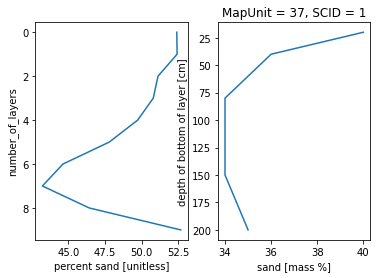

In [9]:
## Open file with target dimensions for CLM
CLMin = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/rawdata/mksrf_soitex.10level.c010119.nc'
dsCLM = xr.open_dataset(CLMin)
print(dsCLM.ZSOI.values)
print((dsLook.BotDep/100).values[0:7])
plt.subplot(1,2,1)
dsCLM.PCT_SAND.sel(max_value_mapunit=37).plot(y='number_of_layers') 
plt.gca().invert_yaxis();
plt.subplot(1,2,2)
dsLook.SDTO.isel(MapUnit = 2, SCID=0).plot(y='BotDep')
plt.gca().invert_yaxis();

- CLM layers 0-3 (<0.16) are 0-20 cm for WISE [0]
- CLM layer 4 (0.29) is 20-40 cm for WISE
- CLM layer 5 (0.49) is 40-60 cm for WISE
* no CLM layer for WISE data 60-80
- CLM layer 6 (0.83) is 80-100 cm for WISE
- CLM layer 7 (1.38) is 100-150 cm for WISE
- CLM layers 8-9 are 150-200 cm for WISE
#### make a new output datset with 10 layers, cooresponding to CLM layers

<xarray.Dataset>
Dimensions:     (MapUnit: 16413, SCID: 10, soil_layer: 10)
Coordinates:
  * soil_layer  (soil_layer) int64 0 1 2 3 4 5 6 7 8 9
  * MapUnit     (MapUnit) int64 2 36 37 38 39 ... 32152 32153 32154 32155 32156
  * SCID        (SCID) int64 1 2 3 4 5 6 7 8 9 10
Data variables: (12/20)
    PRID        (MapUnit, SCID, soil_layer) object 'ACf/A' 'ACf/A' ... nan nan
    Drain       (MapUnit, SCID, soil_layer) object 'W' 'W' 'W' ... nan nan nan
    CFRAG       (MapUnit, SCID, soil_layer) float64 21.0 21.0 21.0 ... nan nan
    SDTO        (MapUnit, SCID, soil_layer) float64 56.0 56.0 56.0 ... nan nan
    STPC        (MapUnit, SCID, soil_layer) float64 20.0 20.0 20.0 ... nan nan
    CLPC        (MapUnit, SCID, soil_layer) float64 24.0 24.0 24.0 ... nan nan
    ...          ...
    TCEQ        (MapUnit, SCID, soil_layer) float64 0.0 0.0 0.0 ... nan nan nan
    ORGC        (MapUnit, SCID, soil_layer) float64 13.99 13.99 ... nan nan
    TOTN        (MapUnit, SCID, soil_layer) float64 1.1 1.1 1.1 ... nan nan nan
    CNrt        (MapUnit, SCID, soil_layer) float64 13.0 13.0 13.0 ... nan nan
    ZSOI        (soil_layer) float32 0.0175 0.0451 0.0906 ... 1.383 2.296 3.433
    DZSOI       (soil_layer) float32 ...
Attributes:
    source data:    https://files.isric.org/public/wise/wise_30sec_v1.zip
    doucmentation:  https://library.wur.nl/WebQuery/wurpubs/fulltext/400244
    publication:    https://doi.org/10.1016/j.geoderma.2016.01.034
    accessed:       11 March, 2022
    notes:          generated by Will Wieder
    source code:    tiff2nc-WISE.ipynb

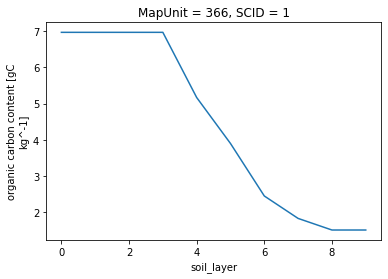

In [10]:
MapUnit = dsLook.MapUnit
SCID = dsLook.SCID
soil_layer = dsCLM.number_of_layers.rename({'number_of_layers':'soil_layer'})
#dsOUT = xr.Dataset(data_vars=None,
#                   coords=({'MapUnit' : MapUnit,    
#                            'SCID': SCID,
#                            'soil_layer': soil_layer}) )
temp0 = dsLook.rename({'BotDep': 'soil_layer'})
var = ['PRID','Drain','CFRAG','SDTO','STPC','CLPC','BULK','TAWC',
       'CECS','CECc','TEB','BSAT','ECEC','PHAQ',
       'TCEQ','ORGC','TOTN','CNrt']

for i in range(len(var)):
    # CLM layers 0:3 in CLM are in WISE layer 0
    temp = temp0[var[i]][:,:,0]
    tempMerge = xr.concat([temp,temp,temp,temp],dim='soil_layer')

    # CLM layer 4:5  in CLM are in WISE layer 1:2
    temp = temp0[var[i]][:,:,1:3]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # CLM layer 6:8  in CLM are in WISE layer 4:6
    temp = temp0[var[i]][:,:,4:]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # CLM layer 9  in CLM are in WISE layer 6
    temp = temp0[var[i]][:,:,6]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')
    if i == 0:
        dsOUT = tempMerge.to_dataset(name=var[i])
    else:
        dsOUT[var[i]] = tempMerge

# switch to CLM soil layer convention
dsOUT['soil_layer'] = soil_layer
dsOUT['ORGC'].isel(MapUnit=100,SCID=0).plot() ; 
dsOUT.attrs = dsLook.attrs
dsOUT['ZSOI'] = dsCLM.ZSOI.rename({'number_of_layers':'soil_layer'})
dsOUT['DZSOI']= dsCLM.DZSOI.rename({'number_of_layers':'soil_layer'})
dsOUT = dsOUT.transpose("MapUnit", "SCID", "soil_layer")
dsOUT

## open .tif as rioxarray to bring in meta and projection data

In [11]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    rds = rioxarray.open_rasterio(infile)

rds = rds.rename({'x': 'lon','y': 'lat'})
rds = rds.isel(band=0).to_dataset(name='MU')
rds = rds.reset_coords(names=['spatial_ref','band'], drop=True)
rds = rds.astype(int)
rds = rds.where(rds>0)
rds 

<xarray.Dataset>
Dimensions:  (lat: 16753, lon: 43201)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 83.62 83.61 83.6 83.6 ... -55.95 -55.96 -55.97 -55.98
Data variables:
    MU       (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [12]:
## Check to see that dimensions are the same for lookup table and grid
df  = rds.to_dataframe()
df.MU.attrs['_FillValue'] = 0
print('gridded unique profiles = ' + str(len(df.MU.unique()) ) )
print('Lookup unique profiles = ' + str(len(dsOUT.MapUnit) ) )
print(' -- grid has extra value for missing data, ocean -- ')

gridded unique profiles = 16414
Lookup unique profiles = 16413
 -- grid has extra value for missing data, ocean -- 


In [13]:
df.MU = df.MU.where(df.MU>0)
print('min mapunit lookup = '+str(dsOUT['MapUnit'].values.min())+', grid ='+str(df.MU.min()) )
print('max mapunit lookup = '+str(dsOUT['MapUnit'].values.max())+', grid ='+str(df.MU.max()) )

min mapunit lookup = 2, grid =2.0
max mapunit lookup = 32156, grid =32156.0


In [14]:
## now merge the datasets 
rds.MU.attrs['long_name']= 'WISE30sec MapUnit'
ds = xr.merge([rds,dsOUT])
ds = ds.rename({'SDTO':'PCT_SAND',
                'STPC':'PCT_SILT',
                'CLPC':'PCT_CLAY',
               })
ds.attrs = dsOUT.attrs
ds

<xarray.Dataset>
Dimensions:     (MapUnit: 16413, SCID: 10, lat: 16753, lon: 43201, soil_layer: 10)
Coordinates:
  * lon         (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat         (lat) float64 83.62 83.61 83.6 83.6 ... -55.96 -55.97 -55.98
  * soil_layer  (soil_layer) int64 0 1 2 3 4 5 6 7 8 9
  * MapUnit     (MapUnit) int64 2 36 37 38 39 ... 32152 32153 32154 32155 32156
  * SCID        (SCID) int64 1 2 3 4 5 6 7 8 9 10
Data variables: (12/21)
    MU          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    PRID        (MapUnit, SCID, soil_layer) object 'ACf/A' 'ACf/A' ... nan nan
    Drain       (MapUnit, SCID, soil_layer) object 'W' 'W' 'W' ... nan nan nan
    CFRAG       (MapUnit, SCID, soil_layer) float64 21.0 21.0 21.0 ... nan nan
    PCT_SAND    (MapUnit, SCID, soil_layer) float64 56.0 56.0 56.0 ... nan nan
    PCT_SILT    (MapUnit, SCID, soil_layer) float64 20.0 20.0 20.0 ... nan nan
    ...          ...
    TCEQ        (MapUnit, SCID, soil_layer) float64 0.0 0.0 0.0 ... nan nan nan
    ORGC        (MapUnit, SCID, soil_layer) float64 13.99 13.99 ... nan nan
    TOTN        (MapUnit, SCID, soil_layer) float64 1.1 1.1 1.1 ... nan nan nan
    CNrt        (MapUnit, SCID, soil_layer) float64 13.0 13.0 13.0 ... nan nan
    ZSOI        (soil_layer) float32 0.0175 0.0451 0.0906 ... 1.383 2.296 3.433
    DZSOI       (soil_layer) float32 0.0175 0.0276 0.0455 ... 0.9133 1.137
Attributes:
    source data:    https://files.isric.org/public/wise/wise_30sec_v1.zip
    doucmentation:  https://library.wur.nl/WebQuery/wurpubs/fulltext/400244
    publication:    https://doi.org/10.1016/j.geoderma.2016.01.034
    accessed:       11 March, 2022
    notes:          generated by Will Wieder
    source code:    tiff2nc-WISE.ipynb

In [15]:
## Write out .nc file
fout = path + 'wise_30sec_v1.nc'
ds.to_netcdf(fout)
print('wrote '+fout)

wrote /glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/wise_30sec_v1.nc


In [ ]:
# This takes forver
ds.MU.plot() ;

-------

In [ ]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python